# Vocal tract tuner


Tune a resonance of the vocal tract to bore

In [1]:
%pylab inline
from copy import deepcopy
from reed_up_downstream_dyn import ReedSimulation, calc_fixed_point
from json_object import JSONObject
from pypevoc.PVAnalysis import PV
from pypevoc.Heterodyne import HeterodyneHarmonic
from pypevoc.SoundUtils import FuncWind
from scipy.optimize import fsolve
import numpy as np
import scipy.signal as sig
import pickle
import multiprocessing




Populating the interactive namespace from numpy and matplotlib


In [2]:
def imp_resp(js, nfft=1024, tract=None):
    sim = ReedSimulation()
    sim.from_json(js)
    if tract is None:
        imps = {}
        for t in sim.tracts.keys():
            imps[t] = sim.tracts[t].impulse_response(n=nfft)
        return imps
    else:
        impresp = sim.tracts[tract].impulse_response(n=nfft)
        return impresp

def ir_to_z(ir,nfft=None):
    rf = np.fft.fft(ir, n=nfft)
    z = (1+rf)/(1-rf)
    return z
    
def impedance(js,n_ir=1024,nfft=None,tract=None):
    imps = imp_resp(js,nfft=n_ir,tract=tract)
    if nfft is None:
        nfft=n_ir
    sr = js['simulation/sample rate']
    f = np.arange(nfft)/nfft*sr
    if tract is None:
        zs={}
        for k,v in imps.items():
            zs[k] = ir_to_z(v,nfft=nfft)
        return zs, f
    else:
        return ir_to_z(imps,nfft=nfft), f
    
def bodeplot(x, z, ax=None, label=None):
    if ax is None:
        fig, ax = plt.subplots(2, sharex=True)
    ax[0].semilogy(x,np.abs(z),label=label)
    ax[1].plot(x,np.angle(z),label=label)
    return ax

In [102]:
jsfile = 'tongue_2seg_shortVt_open_simulation_with_tuning.json'

with open(jsfile) as f:
    js = JSONObject(f)

dx = js['environment/acoustic/speed of sound']/js['simulation/sample rate']
n_main = 1

tongue_rad_list=[0.02,0.015,0.01,0.008,0.006,0.004,0.003,0.0015]
#tongue_rad_list=[0.015,0.008,0.005,0.003]

js['tracts/vocal/elements/0/radius']=0.015

In [103]:
zs, f = impedance(js,nfft=2**14)

No radiation filter


(0, 1500)

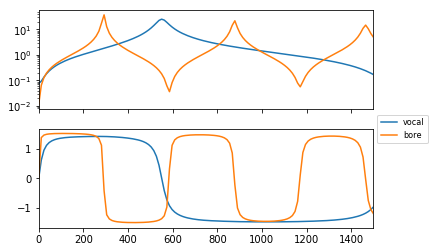

In [106]:
fig,ax = plt.subplots(2,sharex=True)
for k,v in zs.items():
    ax=bodeplot(f, v,label=k,ax=ax)
ax[1].legend(fontsize=8, bbox_to_anchor=(1,1),loc='center left')
ax[0].set_xlim(0,1500)

In [95]:
for k,v in zs.items():
    pks,_=sig.find_peaks(np.abs(v))
    print(f[pks[:5]])

[ 820.3125  2332.03125 3269.53125 4687.5     6351.5625 ]
[ 292.96875  878.90625 1464.84375 2050.78125 2636.71875]


In [96]:
def tune_peak(js_orig,target_f,peak=None,tolerance=1.,maxit=5,nfft=2**14, element=1):
    js = js_orig.copy()
    for ii in range(maxit):
        z, f = impedance(js,nfft=nfft,tract='vocal')
        jst = js['tracts/vocal/elements']
        vtlen = sum([el['length'] for el in jst if el['type']=='cylinder'])
        pks,_=sig.find_peaks(np.abs(z))
        fpks = f[pks]
        if peak is None:
            peak = np.argmin(np.abs(fpks-target_f))
        df = fpks[peak]-target_f
        newl = vtlen*fpks[peak]/target_f
        dl = newl-vtlen+js['tracts/vocal/elements/{}/length'.format(element)]
        js['tracts/vocal/elements/{}/length'.format(element)] = dl
        print(target_f,fpks[peak],newl,vtlen,js['tracts/vocal/elements/{}/length'.format(element)],df)
        if np.abs(df)<tolerance:
            break
    return js

In [97]:
jstuned=tune_peak(js,f[sig.find_peaks(np.abs(zs['bore']))[0]][1])

No radiation filter
878.90625 820.3125 0.11666666666666667 0.125 0.08666666666666667 -58.59375
No radiation filter
878.90625 902.34375 0.11977777777777777 0.11666666666666667 0.08977777777777778 23.4375
No radiation filter
878.90625 867.1875 0.11818074074074073 0.11977777777777777 0.08818074074074073 -11.71875
No radiation filter
878.90625 890.625 0.11975648395061728 0.11818074074074073 0.08975648395061728 11.71875
No radiation filter
878.90625 867.1875 0.11815973083127572 0.11975648395061728 0.08815973083127572 -11.71875


No radiation filter


(0, 4000)

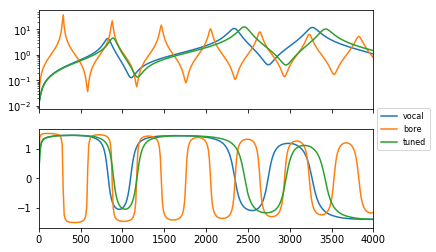

In [98]:
fig,ax = plt.subplots(2,sharex=True)
for k,v in zs.items():
    ax=bodeplot(f, v,label=k,ax=ax)
ztuned, f = impedance(jstuned,tract='vocal',nfft=2**14)
ax=bodeplot(f, ztuned,label='tuned',ax=ax)
ax[1].legend(fontsize=8, bbox_to_anchor=(1,1),loc='center left')
ax[0].set_xlim(0,4000)

In [100]:
main_vt_len_dict = {}
for r in tongue_rad_list:
    jsc = js.copy()
    jsc['tracts/vocal/elements/0/radius']=r
    jstuned=tune_peak(jsc,f[sig.find_peaks(np.abs(zs['bore']))[0]][1])
    main_vt_len_dict[r]=jstuned['tracts/vocal/elements/1/length']

No radiation filter
878.90625 457.03125 0.065 0.125 0.035 -421.875
No radiation filter
878.90625 820.3125 0.06066666666666667 0.065 0.03066666666666667 -58.59375
No radiation filter
878.90625 867.1875 0.05985777777777778 0.06066666666666667 0.02985777777777778 -11.71875
No radiation filter
878.90625 867.1875 0.05905967407407408 0.05985777777777778 0.02905967407407408 -11.71875
No radiation filter
878.90625 902.34375 0.06063459871604939 0.05905967407407408 0.030634598716049392 23.4375
No radiation filter
878.90625 550.78125 0.07833333333333334 0.125 0.04833333333333334 -328.125
No radiation filter
878.90625 843.75 0.0752 0.07833333333333334 0.045200000000000004 -35.15625
No radiation filter
878.90625 890.625 0.07620266666666668 0.0752 0.046202666666666684 11.71875
No radiation filter
878.90625 867.1875 0.07518663111111112 0.07620266666666668 0.045186631111111125 -11.71875
No radiation filter
878.90625 890.625 0.07618911952592594 0.07518663111111112 0.04618911952592594 11.71875
No radiat

In [101]:
main_vt_len_dict

{0.02: 0.030634598716049392,
 0.015: 0.04618911952592594,
 0.01: 0.06924444444444444,
 0.008: 0.07921791336296298,
 0.006: 0.08625320296296296,
 0.004: 0.0916,
 0.003: 0.09166666666666667,
 0.0015: 0.09155733333333334}

In [67]:
[[k,v] for k,v in main_vt_len_dict.items()]

[[0.02, 0.09705464909865272],
 [0.015, 0.1326027397260274],
 [0.01, 0.16329209263348388],
 [0.008, 0.17943091668228756],
 [0.006, 0.18477824876547813],
 [0.004, 0.1893602987979393],
 [0.003, 0.19988585823287583],
 [0.0015, 0.19178082191780824]]